Import data

In [191]:
import numpy as np
import pandas as pd
# Import data from csv
data = pd.read_csv('App/Daten/data_new/detail.csv')

In [192]:
data.columns

Index(['BETRIEBSTAG', 'AN_diff', 'weekday', 'ab_hour', 'ab_minute', 'feiertag',
       'Temperatur', 'Niederschlag', 'Luftfeuchtigkeit', 'Wind', 'week',
       'haltestelle_ab_Basel SBB', 'haltestelle_ab_Bern',
       'haltestelle_ab_Lugano', 'haltestelle_ab_Luzern',
       'haltestelle_ab_Olten', 'haltestelle_ab_St. Gallen',
       'haltestelle_ab_Zürich HB', 'haltestelle_an_Basel SBB',
       'haltestelle_an_Bern', 'haltestelle_an_Lugano', 'haltestelle_an_Luzern',
       'haltestelle_an_Olten', 'haltestelle_an_St. Gallen',
       'haltestelle_an_Zürich HB', 'LINIEN_TEXT_EC', 'LINIEN_TEXT_IC1',
       'LINIEN_TEXT_IC2', 'LINIEN_TEXT_IC21', 'LINIEN_TEXT_IC3',
       'LINIEN_TEXT_IC5', 'LINIEN_TEXT_IC6', 'LINIEN_TEXT_IC61',
       'LINIEN_TEXT_IC8', 'LINIEN_TEXT_IC81', 'LINIEN_TEXT_ICE',
       'LINIEN_TEXT_IR15', 'LINIEN_TEXT_IR16', 'LINIEN_TEXT_IR26',
       'LINIEN_TEXT_IR27', 'LINIEN_TEXT_IR36', 'LINIEN_TEXT_IR37',
       'Einschr_type_Aufgehoben:', 'Einschr_type_Einschraenkung',
  

In [193]:
betriebstage = data['BETRIEBSTAG']
data.drop('BETRIEBSTAG', axis=1, inplace=True)

In [194]:
# Assuming your dataframe is called 'df' and the dummy columns start with 'departure_'
data['haltestelle_ab'] = data.filter(like='haltestelle_ab_').idxmax(axis=1)
data['haltestelle_ab'] = data['haltestelle_ab'].str.replace('haltestelle_ab_', '')
data.drop(data.filter(like='haltestelle_ab_').columns, axis=1, inplace=True)


In [195]:
data

,AN_diff,weekday,ab_hour,ab_minute,feiertag,Temperatur,Niederschlag,Luftfeuchtigkeit,Wind,week,...,LINIEN_TEXT_IR26,LINIEN_TEXT_IR27,LINIEN_TEXT_IR36,LINIEN_TEXT_IR37,Einschr_type_Aufgehoben:,Einschr_type_Einschraenkung,Einschr_type_Endmeldung:,Einschr_type_Keine,Einschr_type_Unterbruch,haltestelle_ab
0,118.650000,5,1,47,0,11.0,8.0,84.6,7.5,12,...,0,0,0,0,0,0,0,1,0,Olten
1,118.650000,5,1,6,0,1.2,4.8,75.3,6.8,12,...,0,0,0,0,0,0,0,1,0,Bern
2,118.200000,5,17,29,0,8.0,9.9,86.9,5.1,37,...,0,0,0,0,0,0,0,1,0,St. Gallen
3,117.116667,1,11,2,0,-0.3,7.0,78.2,3.6,23,...,0,0,0,0,0,0,0,1,0,Basel SBB
4,116.750000,4,20,59,0,20.0,0.0,86.6,3.3,40,...,0,0,0,0,0,0,0,1,0,Olten
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423222,-14.266667,1,7,48,0,-6.0,0.0,83.4,4.2,50,...,0,0,0,0,0,0,0,1,0,Basel SBB
423223,-14.866667,5,20,13,0,-1.6,0.0,72.0,4.0,4,...,0,0,0,0,0,0,0,1,0,Basel SBB
423224,-15.050000,5,17,13,0,-1.6,0.0,72.0,4.0,4,...,0,0,0,0,0,0,0,1,0,Basel SBB
423225,-15.266667,6,6,13,0,-1.7,0.0,81.1,1.9,4,...,0,0,0,0,0,0,0,1,0,Basel SBB


In [196]:
haltestellen = data['haltestelle_ab'].unique()
haltestellen

array(['Olten', 'Bern', 'St. Gallen', 'Basel SBB', 'Lugano', 'Luzern',
       'Zürich HB'], dtype=object)

In [197]:
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import pickle
from joblib import dump

models per station

In [198]:
# Initialize dictionary for storing models for each departure station
models_per_station = {}

# Initialize dictionary for storing results per station
results_per_station = {}

for station in haltestellen:
    # Filter the data for the current departure station
    data_station = data[data['haltestelle_ab'] == station]

    # Drop the departure station column
    data_station = data_station.drop('haltestelle_ab', axis=1)

    # Define X and y
    X = data_station.drop('AN_diff', axis=1)
    y = data_station['AN_diff']

    # Split data into train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=4153)

    models = [
        # ('LinearRegression', LinearRegression()),
        ('RandomForestRegressor', RandomForestRegressor(random_state=4153)),
        ('XGBRegressor', XGBRegressor(random_state=4153))
    ]

    # Initialize list for base estimators of VotingRegressor
    estimators = {}

    # Initialize empty dataframe for results
    all_results_voting = pd.DataFrame()

    for name, model in models:
        model.fit(X_train, y_train)

        # Add the model to the estimators list
        estimators[name] = model

        # Predict y
        y_pred = model.predict(X_test)

        # Calculate metrics
        r2 = r2_score(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        mape = mean_absolute_percentage_error(y_test, y_pred)

        # Save results in a dictionary
        result = {'R2': r2, 'RMSE': rmse, 'MAPE': mape, 'modelname': name}

        # Add to results dataframe
        all_results_voting = pd.concat([all_results_voting, pd.DataFrame([result])], ignore_index=True)

    # find best model 
    best_model_name = 'XGBRegressor' # all_results_voting.sort_values(by=['RMSE']).iloc[0]['modelname']
    best_model = estimators[best_model_name]
    # save best model
    with open(f'App/Modell/Orte/{station}_{best_model_name}.pkl', 'wb') as f:
        pickle.dump(best_model, f)

    # Voting Regressor
    voting_regressor = VotingRegressor(list(estimators.items()))
    voting_regressor.fit(X_train, y_train)

    # Add model to estimators list
    estimators['VotingRegressor'] = voting_regressor

    # Predict y
    y_pred = voting_regressor.predict(X_test)

    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Save results in a dictionary
    result = {'R2': r2, 'RMSE': rmse, 'MAPE': mape, 'modelname': 'VotingRegressor'}

    # Add to results dataframe
    all_results_voting = pd.concat([all_results_voting, pd.DataFrame([result])], ignore_index=True)

    # Save the models and results for this departure station
    models_per_station[station] = estimators
    results_per_station[station] = all_results_voting

plot

In [199]:
# Concatenate dataframes and add station column
all_results = pd.concat([df.assign(station=station) for station, df in results_per_station.items()])
# Add number of entries per station
entries = data.groupby('haltestelle_ab').count()['AN_diff'].reset_index()
all_results = pd.merge(all_results, entries, left_on='station', right_on='haltestelle_ab', how='left').drop('haltestelle_ab', axis=1).rename(columns={'AN_diff': 'entries'})
all_results.to_csv('App/Modell/Orte/metrics.csv', index=False)

In [200]:
import matplotlib.pyplot as plt
import seaborn as sns

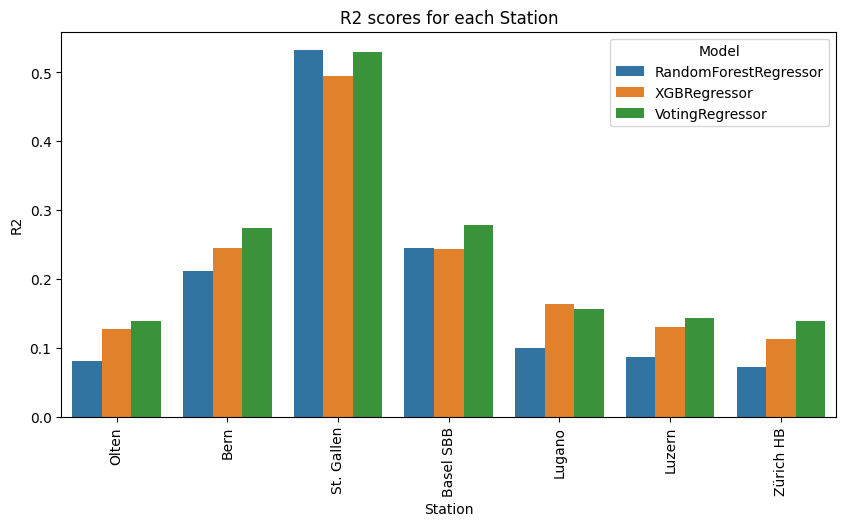

In [201]:
# Plot results
plt.figure(figsize=(10, 5))
sns.barplot(data=all_results, x='station', y='R2', hue='modelname')
plt.title('R2 scores for each Station')
plt.ylabel('R2')
plt.xlabel('Station')
plt.xticks(rotation=90)
plt.legend(title='Model')
plt.show()

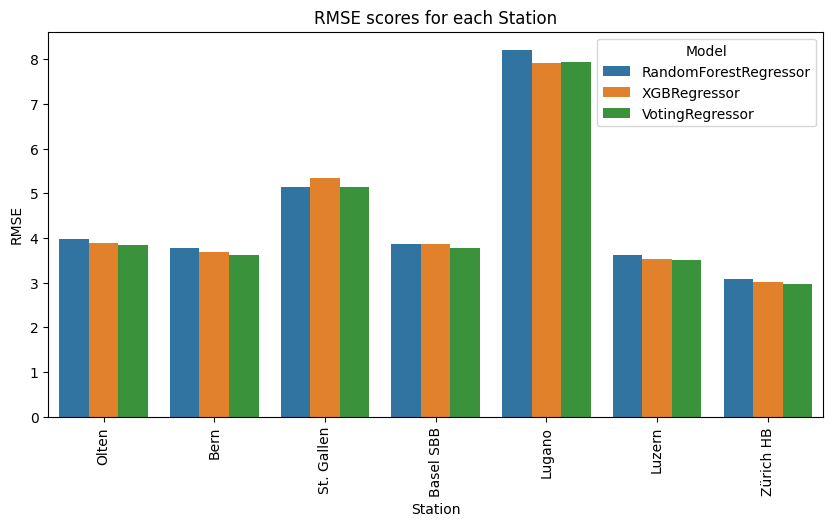

In [202]:
# Concatenate dataframes and add station column
all_results = pd.concat([df.assign(station=station) for station, df in results_per_station.items()])

# Plot results
plt.figure(figsize=(10, 5))
sns.barplot(data=all_results, x='station', y='RMSE', hue='modelname')
plt.title('RMSE scores for each Station')
plt.ylabel('RMSE')
plt.xlabel('Station')
plt.xticks(rotation=90)
plt.legend(title='Model')
plt.show()

betriebstag

In [203]:
data_full = pd.concat([data, betriebstage], axis=1)
data_full['BETRIEBSTAG'] = pd.to_datetime(data_full['BETRIEBSTAG'])
data_full['BETRIEBSTAG'] = data_full['BETRIEBSTAG'].dt.day_of_year.astype(int)
data_full.head(2)

,AN_diff,weekday,ab_hour,ab_minute,feiertag,Temperatur,Niederschlag,Luftfeuchtigkeit,Wind,week,...,LINIEN_TEXT_IR27,LINIEN_TEXT_IR36,LINIEN_TEXT_IR37,Einschr_type_Aufgehoben:,Einschr_type_Einschraenkung,Einschr_type_Endmeldung:,Einschr_type_Keine,Einschr_type_Unterbruch,haltestelle_ab,BETRIEBSTAG
0,118.65,5,1,47,0,11.0,8.0,84.6,7.5,12,...,0,0,0,0,0,0,1,0,Olten,84
1,118.65,5,1,6,0,1.2,4.8,75.3,6.8,12,...,0,0,0,0,0,0,1,0,Bern,84


In [204]:
# Initialize dictionary for storing models for each departure station
models_per_station_full = {}

# Initialize dictionary for storing results per station
results_per_station_full = {}

for station in haltestellen:
    # Filter the data for the current departure station
    data_station = data_full[data_full['haltestelle_ab'] == station]

    # Drop the departure station column
    data_station = data_station.drop('haltestelle_ab', axis=1)

    # Define X and y
    X = data_station.drop('AN_diff', axis=1)
    y = data_station['AN_diff']

    # Split data into train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=4153)

    models = [
        # ('LinearRegression', LinearRegression()),
        ('RandomForestRegressor', RandomForestRegressor(random_state=4153)),
        ('XGBRegressor', XGBRegressor(random_state=4153))
    ]

    # Initialize list for base estimators of VotingRegressor
    estimators = {}

    # Initialize empty dataframe for results
    all_results_voting = pd.DataFrame()

    for name, model in models:
        model.fit(X_train, y_train)

        # Add the model to the estimators list
        estimators[name] = model

        # Predict y
        y_pred = model.predict(X_test)

        # Calculate metrics
        r2 = r2_score(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        mape = mean_absolute_percentage_error(y_test, y_pred)

        # Save results in a dictionary
        result = {'R2': r2, 'RMSE': rmse, 'MAPE': mape, 'modelname': name}

        # Add to results dataframe
        all_results_voting = pd.concat([all_results_voting, pd.DataFrame([result])], ignore_index=True)

    # # find best model 
    # best_model_name = 'XGBRegressor' # all_results_voting.sort_values(by=['RMSE']).iloc[0]['modelname']
    # best_model = estimators[best_model_name]
    # # save best model
    # with open(f'App/Modell/Orte/{station}_{best_model_name}.pkl', 'wb') as f:
    #     pickle.dump(best_model, f)

    # Voting Regressor
    voting_regressor = VotingRegressor(list(estimators.items()))
    voting_regressor.fit(X_train, y_train)

    # Add model to estimators list
    estimators['VotingRegressor'] = voting_regressor

    # Predict y
    y_pred = voting_regressor.predict(X_test)

    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Save results in a dictionary
    result = {'R2': r2, 'RMSE': rmse, 'MAPE': mape, 'modelname': 'VotingRegressor'}

    # Add to results dataframe
    all_results_voting = pd.concat([all_results_voting, pd.DataFrame([result])], ignore_index=True)

    # Save the models and results for this departure station
    models_per_station_full[station] = estimators
    results_per_station_full[station] = all_results_voting

plot

In [205]:
# append _full to entries in columns station
all_results_full = pd.concat([df.assign(station=station) for station, df in results_per_station_full.items()])

all_results_full['modelname'] = all_results_full['modelname'].apply(lambda x: x + '_full')

# Concatenate dataframes and add station column
results = pd.concat([all_results, all_results_full], axis=0).sort_values(by=['station', 'modelname'])

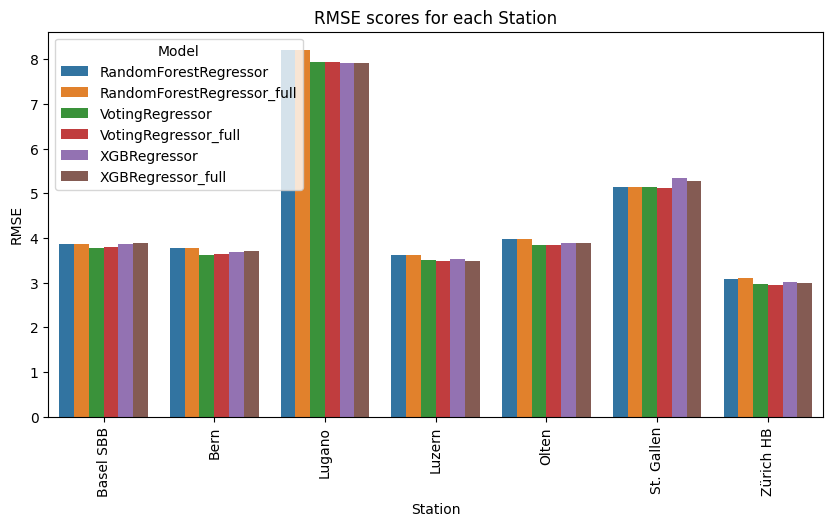

In [206]:
# Plot results
plt.figure(figsize=(10, 5))
sns.barplot(data=results, x='station', y='RMSE', hue='modelname')
plt.title('RMSE scores for each Station')
plt.ylabel('RMSE')
plt.xlabel('Station')
plt.xticks(rotation=90)
plt.legend(title='Model')
plt.show()

In [207]:
results

,R2,RMSE,MAPE,modelname,station
0,0.244471,3.865875,3.722968e+13,RandomForestRegressor,Basel SBB
0,0.246626,3.860357,3.697194e+13,RandomForestRegressor_full,Basel SBB
2,0.278537,3.777714,3.076268e+13,VotingRegressor,Basel SBB
2,0.274569,3.788090,3.088932e+13,VotingRegressor_full,Basel SBB
1,0.244136,3.866732,2.609202e+13,XGBRegressor,Basel SBB
1,0.236501,3.886211,2.643009e+13,XGBRegressor_full,Basel SBB
0,0.211354,3.764110,3.200146e+13,RandomForestRegressor,Bern
0,0.205669,3.777654,3.252028e+13,RandomForestRegressor_full,Bern
2,0.274562,3.610118,3.269729e+13,VotingRegressor,Bern
2,0.266410,3.630346,3.261630e+13,VotingRegressor_full,Bern
